In [90]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 
import wandb

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

sys.path.append("../")
from src.model import LightGBMModel
from src.validation import caluculate_metrics



# Config

In [92]:
class cfg:
    project = "numerai_tournament"
    exp = "exp020"
    dataset_path = "../dataset/v5.0"
    feature_set = "small"
    valid_ratio = 0.2
    description = "wandb 導入した最初の実行"
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }

has_init_wandb = False
if not has_init_wandb:
    wandb.init(project=cfg.project, name=cfg.exp)
    wandb.log({
        "description": cfg.description,
        "feature_set": cfg.feature_set,
    })
    has_init_wandb = True

In [77]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set][:80]
print(f"feature col length: {len(feature_set)}")


targets = feature_metadata["targets"]
targets = ["target", "target_agnes_20"]
targets = [targets[0]]

feature col length: 42


# Load Data

In [78]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
    
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 44)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,target
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,2,2,2,2,2,0,1,2,2,...,1,1,3,0,2,2,3,3,2,0.25
n003bba8a98662e4,0001,2,2,2,2,2,1,4,2,2,...,2,0,0,0,2,2,4,4,2,0.25


(3590190, 44)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,target
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0,2,1,2,2,1,1,2,2,...,2,3,0,2,2,1,3,2,0,0.75
n001e1318d5072ac,0575,1,1,3,2,1,3,3,4,4,...,4,3,2,2,3,1,1,0,1,0.00


# Preprocess

In [79]:
# 学習データを増やす (train, valid を合体してから分ける)
print(train.shape, valid.shape)

data = pd.concat([train, valid])
display(data.tail())

# era 単位で分ける
all_era = data["era"].unique()
n_idx = int(len(all_era) * (1 - cfg.valid_ratio))
print(data.shape)
print(n_idx)

train_era = all_era[:n_idx]
cond_train = data["era"].isin(train_era)
train, valid = data.loc[cond_train], data.loc[~cond_train]

print(train.shape, valid.shape)


(2746270, 44) (3590190, 44)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,target
id,,,,,,,,,,,,,,,,,,,,,
nffddb5d88eac837,1155,1,2,4,1,1,4,3,2,3,...,4,3,2,3,0,1,3,1,1,NaN
nffe2864d87608a4,1155,4,4,2,4,4,3,1,1,1,...,2,0,4,0,2,2,3,3,0,NaN
nffe68d1b4270d67,1155,2,0,1,0,3,0,2,3,0,...,3,1,0,3,2,3,4,4,4,NaN
nffeedfcd8ee0a13,1155,2,1,1,2,2,4,2,2,2,...,1,0,0,4,2,2,4,0,2,NaN
nfff368efc94f367,1155,4,2,3,3,3,3,4,4,0,...,2,4,2,4,1,0,3,3,2,NaN


(6336460, 44)
924
(4830256, 44) (1506204, 44)


In [80]:
train["era_int"] = train["era"].astype(int)

/tmp/ipykernel_147211/1731592198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["era_int"] = train["era"].astype(int)


# Training

In [81]:
features = feature_set


In [82]:
models = []

for target in targets:
    print("=" * 64)
    print("target: ", target)
    for i in range(4):
        cond_train = (train["era_int"] % 4 == i) & (~train[target].isnull())
        cond_valid = ~valid[target].isnull()
        tmp_train = train.loc[cond_train]
        tmp_valid = valid.loc[cond_valid]

        model = LightGBMModel(
            model_params=cfg.model_params,
        )
        model.train(
            tmp_train[features],
            tmp_train[target],
            eval_set=(tmp_valid[features], tmp_valid[target]),
            early_stopping_rounds=10
        )
        models.append(model)
        model.save_model(os.path.join(cfg.exp, f"model_{i}_{target}.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

target:  target


/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

4


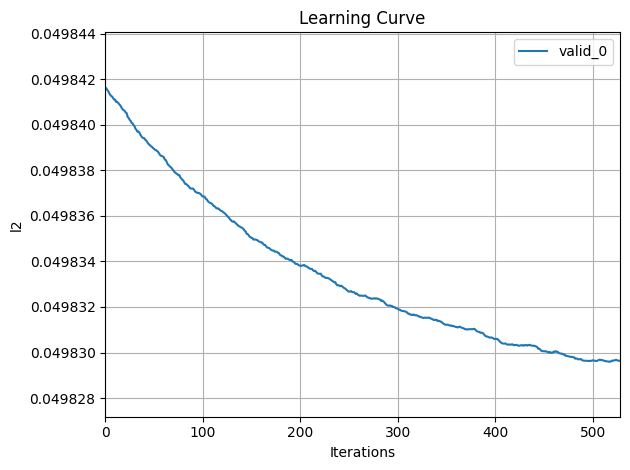

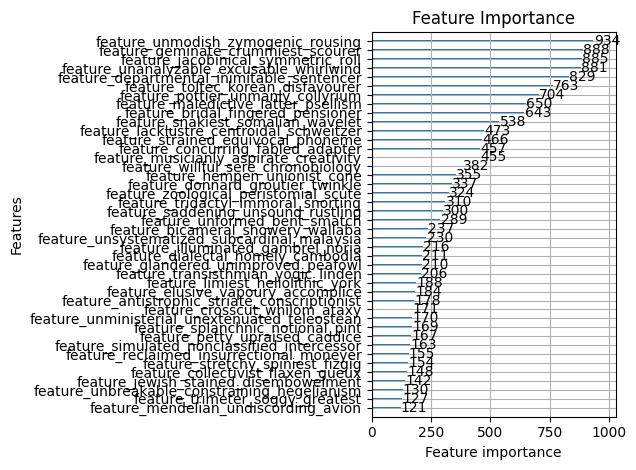

In [83]:
print(len(models))

for model in models:
    model.visualize_learning_curve()
    model.visualize_feature_importance()
    break

# Validation

/tmp/ipykernel_147211/4041851832.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["pred"] = preds


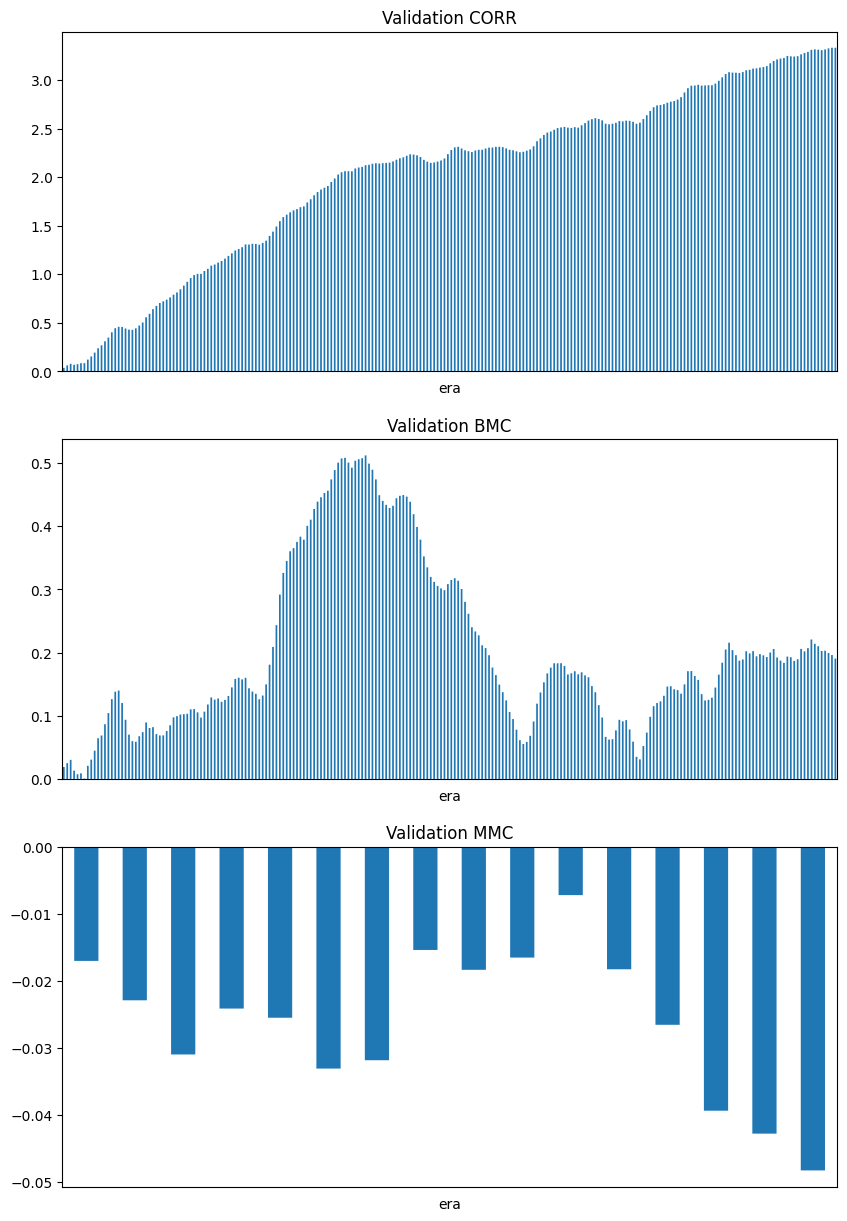

In [84]:
preds = np.zeros(len(valid))

for model in models:
    preds += model.predict(valid[features]) / len(models)

valid["pred"] = preds
result, per_era_corr, per_era_bmc, per_era_mmc = caluculate_metrics(cfg.dataset_path, valid)


In [85]:
per_era_corr["pred"].sum()

3.3317107258840544

In [88]:
# 損益曲線も wandb上で可視化したかったが log で送ると GUI がバグる
# 総和を連携する

per_era_d = {
    "per_era_corr": per_era_corr,
    "per_era_bmc": per_era_bmc,
    "per_era_mmc": per_era_mmc,
}


for key, val in per_era_d.items():
    print(key)
    # display(val.head())
    total_val = val["pred"].sum()
    wandb.log({
        key: total_val
        # key: []
    })
    

per_era_corr
per_era_bmc
per_era_mmc


In [89]:
cond = ~valid["target"].isnull()
tmp_valid = valid.loc[cond]
mse = round(mean_squared_error(tmp_valid["pred"], tmp_valid["target"]), 6)

print(mse)
result_d = {key: round(val[0], 6)for key, val in result.to_dict().items()}
n_features = len(features)

result_d["mse"] = mse
result_d["targets"] = targets

print(result_d)
wandb.log(result_d)

0.04983
{'corr_mean': 0.014742, 'corr_std': 0.017491, 'corr_shape': 0.842815, 'corr_max_drawdown': 0.088549, 'mmc_mean': -0.00302, 'mmc_std': 0.008643, 'mmc_shape': -0.349406, 'mmc_max_drawdown': 0.041114, 'bmc_mean': 0.000843, 'bmc_std': 0.013, 'bmc_shape': 0.064834, 'bmc_max_drawdown': 0.481011, 'mse': 0.04983, 'targets': ['target']}


In [93]:
wandb.finish()

bmc_max_drawdown,▁▁▁
bmc_mean,▁▁▁
bmc_shape,▁▁▁
bmc_std,▁▁▁
corr_max_drawdown,▁▁▁
corr_mean,▁▁▁
corr_shape,▁▁▁
corr_std,▁▁▁
mmc_max_drawdown,▁▁▁
mmc_mean,▁▁▁
mmc_shape,▁▁▁
